In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Flatten, Dropout
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [3]:
# WISDM

columns_wisdm = ['user', 'activity', 'time', 'x_axis', 'y_axis', 'z_axis']
data = pd.read_csv('/content/drive/MyDrive/MCA Main Project/WISDM_ar_v1.1_raw.txt', header=None, names = columns_wisdm)
data = data.dropna()
data.head()

data = data.drop(['user','time'], axis = 1).copy()
data

,activity,x_axis,y_axis,z_axis
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
1098199,Sitting,9.000000,-1.570000,1.690000
1098200,Sitting,9.040000,-1.460000,1.730000
1098201,Sitting,9.080000,-1.380000,1.690000
1098202,Sitting,9.000000,-1.460000,1.730000


In [4]:
# LSTM

columns = ['activity', 'x_axis', 'y_axis', 'z_axis']
df = pd.read_csv('/content/drive/MyDrive/MCA Main Project/HAPT RawExtracted/TrainingData/Train.txt', header=None, sep = ' ',names = columns)
df = df.dropna()
df.head()

# Applying the condition
df['activity'].mask(df['activity'] == 1, 'Walking', inplace=True)
df['activity'].mask(df['activity'] == 2, 'Upstairs', inplace=True)
df['activity'].mask(df['activity'] == 3, 'Downstairs', inplace=True)
df['activity'].mask(df['activity'] == 4, 'Sitting', inplace=True)
df['activity'].mask(df['activity'] == 5, 'Standing', inplace=True)
df['activity'].mask(df['activity'] == 6, 'Laying', inplace=True)

df
df = df.append(data)

# removing laying activity
df = df[df['activity'] != 'Laying']

df

,activity,x_axis,y_axis,z_axis
0,Walking,1.420833,-0.340278,-0.125000
1,Walking,1.002778,-0.204167,-0.108333
2,Walking,0.683333,-0.061111,-0.108333
3,Walking,0.733333,-0.083333,-0.120833
4,Walking,0.956944,-0.263889,-0.137500
...,...,...,...,...
1098199,Sitting,9.000000,-1.570000,1.690000
1098200,Sitting,9.040000,-1.460000,1.730000
1098201,Sitting,9.080000,-1.380000,1.690000
1098202,Sitting,9.000000,-1.460000,1.730000


In [5]:
df.head(11)

,activity,x_axis,y_axis,z_axis
0,Walking,1.420833,-0.340278,-0.125000
1,Walking,1.002778,-0.204167,-0.108333
2,Walking,0.683333,-0.061111,-0.108333
3,Walking,0.733333,-0.083333,-0.120833
4,Walking,0.956944,-0.263889,-0.137500
5,Walking,1.050000,-0.402778,-0.144444
6,Walking,1.013889,-0.415278,-0.104167
7,Walking,0.950000,-0.393056,-0.105556
8,Walking,0.950000,-0.359722,-0.102778
9,Walking,0.952778,-0.315278,-0.086111


In [6]:
# removing null values

df = df.dropna()
df.shape

(1210045, 4)

In [10]:
df.head()

,activity,x_axis,y_axis,z_axis
0,Walking,1.420833,-0.340278,-0.125000
1,Walking,1.002778,-0.204167,-0.108333
2,Walking,0.683333,-0.061111,-0.108333
3,Walking,0.733333,-0.083333,-0.120833
4,Walking,0.956944,-0.263889,-0.137500


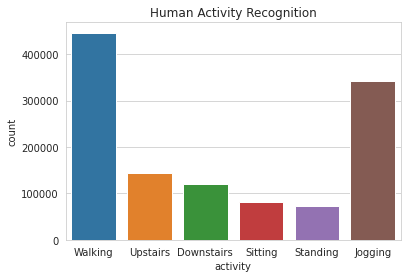

In [11]:
sns.set_style("whitegrid")
sns.countplot(x = 'activity', data = df)
plt.title('Human Activity Recognition')
plt.show()

In [13]:
random_seed = 42
n_time_steps = 50
n_features = 3
step = 10
n_classes = 6
n_epochs = 100
batch_size = 128
learning_rate = 0.0025
l2_loss = 0.0015

In [14]:
segments = []
labels = []

for i in range(0, df.shape[0] - n_time_steps, step):
    
    xs = df['x_axis'].values[i: i + 50]
    ys = df['y_axis'].values[i: i + 50]
    zs = df['z_axis'].values[i: i + 50]
    
    label = stats.mode(df['activity'][i: i + 50])[0][0]
    
    segments.append([xs,ys,zs])
    
    labels.append(label)

# reshape the segments which is(list of arrays) to a list

reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

In [15]:
reshaped_segments.shape

(121000, 50, 3)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=random_seed)

In [17]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Building Model Architecture

model = Sequential()

# GRU layer

model.add(GRU(units=128, input_shape=(X_train.shape[1],X_train.shape[2] )))

# Dropout layer

model.add(Dropout(0.5))

# Dense layer with ReLu

model.add(Dense(units=64, activation='relu'))

# Softmax layer

model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 59,718
Trainable params: 59,718
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=0.2, batch_size=batch_size, verbose=1, callbacks = [callback])

Epoch 1/100
605/605 [==============================] - 10s 7ms/step - loss: 0.6746 - accuracy: 0.7413 - val_loss: 0.4783 - val_accuracy: 0.8089
Epoch 2/100
605/605 [==============================] - 4s 6ms/step - loss: 0.4314 - accuracy: 0.8360 - val_loss: 0.3473 - val_accuracy: 0.8692
Epoch 3/100
605/605 [==============================] - 4s 6ms/step - loss: 0.3141 - accuracy: 0.8840 - val_loss: 0.2425 - val_accuracy: 0.9118
Epoch 4/100
605/605 [==============================] - 4s 6ms/step - loss: 0.2417 - accuracy: 0.9147 - val_loss: 0.2156 - val_accuracy: 0.9239
Epoch 5/100
605/605 [==============================] - 4s 6ms/step - loss: 0.2107 - accuracy: 0.9279 - val_loss: 0.1892 - val_accuracy: 0.9334
Epoch 6/100
605/605 [==============================] - 6s 10ms/step - loss: 0.1872 - accuracy: 0.9360 - val_loss: 0.1823 - val_accuracy: 0.9393
Epoch 7/100
605/605 [==============================] - 4s 7ms/step - loss: 0.1687 - accuracy: 0.9420 - val_loss: 0.1754 - val_accuracy: 0.94

In [20]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size,verbose=1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

190/190 [==============================] - 1s 4ms/step - loss: 0.1441 - accuracy: 0.9531
Test Accuracy : 0.9531404972076416
Test Loss : 0.14410734176635742


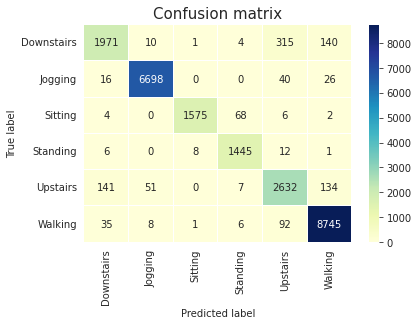

In [21]:
# Confusion matrix

import sklearn.metrics as metrics

predictions = model.predict(X_test)
class_labels = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True,linewidths=0.1,fmt='d', cmap='YlGnBu')
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
# Classification report

class_labels = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
predictions = model.predict(X_test)
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
classification_report = metrics.classification_report(max_test, max_predictions, target_names = class_labels)
print(classification_report)

              precision    recall  f1-score   support

  Downstairs       0.91      0.81      0.85      2441
     Jogging       0.99      0.99      0.99      6780
     Sitting       0.99      0.95      0.97      1655
    Standing       0.94      0.98      0.96      1472
    Upstairs       0.85      0.89      0.87      2965
     Walking       0.97      0.98      0.98      8887

    accuracy                           0.95     24200
   macro avg       0.94      0.93      0.94     24200
weighted avg       0.95      0.95      0.95     24200



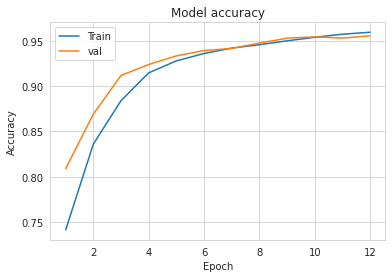

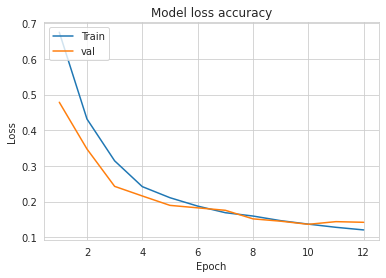

In [24]:
# Learning curves

def plot_learningCurve(history,epochs):

  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss accuracy')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

plot_learningCurve(history,12)